In [5]:
import numpy as np
import matplotlib.pyplot as plt

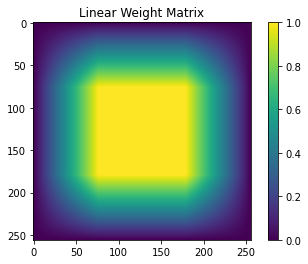

1.0000000000000001e-20


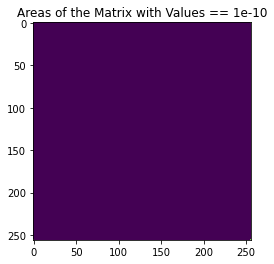

[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [34]:
def linear_weight_matrix(patch_size=256, overlap=0.3): ##########
    overlap = patch_size - int(patch_size * (1 - overlap))
    weight_matrix = np.ones((patch_size, patch_size))

    linear_weight = np.linspace(1e-10, 1, overlap)

    weight_matrix[:overlap, :] *= linear_weight[:, np.newaxis]
    weight_matrix[:, :overlap] *= linear_weight[np.newaxis, :]

    weight_matrix[-overlap:, :] *= linear_weight[::-1][:, np.newaxis]
    weight_matrix[:, -overlap:] *= linear_weight[::-1][np.newaxis, :]
    return weight_matrix[:, :]

def weight_matrix(patch_size=256, overlap=0.3, matrix_type='linear'):
    if matrix_type == 'linear':
        return linear_weight_matrix(patch_size, overlap)
    else:
        raise ValueError(f'Unknown weight matrix type: {matrix_type}')
    
patch_size = 256
matrix = linear_weight_matrix(patch_size)
plt.imshow(matrix)
plt.colorbar()
plt.title("Linear Weight Matrix")
plt.show()
print(np.min(matrix))
thresholded_matrix = np.where(matrix == 1.0000000000000001e-20, 1, 0)  # Mark elements < 1e-10 as 1, else 0
# Plot
plt.imshow(thresholded_matrix)
plt.title("Areas of the Matrix with Values == 1e-10")
plt.show()
# 找到有几行有值
print(np.sum(thresholded_matrix, axis=1))


Unique values of counting:  [1. 2. 3. 4. 6. 9.]


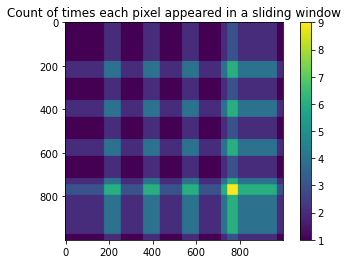

In [10]:
from PIL import Image
patch_size=256
overlap=0.3
stride = int(patch_size * (1 - overlap))
H=1000
W=1000
weights = np.ones((patch_size, patch_size))
count = np.zeros((H, W), dtype=np.float32)
num_patches_h = (H - patch_size) // stride + 1
num_patches_w = (W - patch_size) // stride + 1
if (H - patch_size) % stride != 0:
    num_patches_h += 1
if (W - patch_size) % stride != 0:
    num_patches_w += 1
for i in range(num_patches_h):
    for j in range(num_patches_w):
        # 计算patch的起始坐标
        start_i = min(i * stride, H - patch_size)
        start_j = min(j * stride, W - patch_size)

        count[start_i:start_i + patch_size, start_j:start_j + patch_size] += weights
if np.any(count == 0):
    print(f'Zero count in {np.sum(count == 0)} pixels')

print('Unique values of counting: ', np.unique(count))

# plot 2D array
plt.imshow(count)
plt.title('Count of times each pixel appeared in a sliding window')
plt.colorbar()
plt.show()

# 切割拼接前后对比

In [98]:
def extract_patches(batch, patch_size=256, overlap=0.3):
    stride = int(patch_size * (1 - overlap))
    img = batch['image']
    mask_ = batch['mask']
    nodata_mask = batch['nodata_mask']

    mask = (mask_ | nodata_mask) * 1

    H, W = img.shape
    patches_img = []
    patches_mask = []

    # calculate how many whole complete patches can be extracted
    num_patches_h = (H - patch_size) // stride + 1
    num_patches_w = (W - patch_size) // stride + 1

    if (H - patch_size) % stride != 0:
        num_patches_h += 1
    if (W - patch_size) % stride != 0:
        num_patches_w += 1

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # 计算patch的起始坐标
            start_i = min(i * stride, H - patch_size)
            start_j = min(j * stride, W - patch_size)
            # 提取patch
            p_img = img[start_i:start_i + patch_size, start_j:start_j + patch_size]
            p_mask = mask[start_i:start_i + patch_size, start_j:start_j + patch_size]
            # 将torch tensor patch添加到列表中
            patches_img.append(p_img)
            patches_mask.append(p_mask)
    return patches_img, patches_mask

def linear_weight_matrix(patch_size=256, overlap=0.3): ##########
    overlap = patch_size - int(patch_size * (1 - overlap))
    weight_matrix = np.ones((patch_size, patch_size))

    linear_weight = np.linspace(1e-10, 1, overlap)

    weight_matrix[:overlap, :] *= linear_weight[:, np.newaxis]
    weight_matrix[:, :overlap] *= linear_weight[np.newaxis, :]

    weight_matrix[-overlap:, :] *= linear_weight[::-1][:, np.newaxis]
    weight_matrix[:, -overlap:] *= linear_weight[::-1][np.newaxis, :]
    return weight_matrix[:, :]

In [99]:
def reconstruct_image_weighted(patches, batch, patch_size=256, overlap=0.3, matrix_type='linear'):
    # patch is numpy array, [H, W, C]
    stride = int(patch_size * (1 - overlap))
    img = batch['image']
    H, W = img.shape
    reconstruction = np.zeros((H, W), dtype=np.float32)
    count = np.zeros((H, W), dtype=np.float32)
    # count = np.expand_dims(count, axis=-1)
    weights = linear_weight_matrix(patch_size, overlap)
    ###查看weight matrix维度是否正确

    num_patches_h = (H - patch_size) // stride + 1
    num_patches_w = (W - patch_size) // stride + 1

    if (H - patch_size) % stride != 0:
        num_patches_h += 1
    if (W - patch_size) % stride != 0:
        num_patches_w += 1

    patch_index = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # 计算patch的起始坐标
            start_i = min(i * stride, H - patch_size)
            start_j = min(j * stride, W - patch_size)

            reconstruction[start_i:start_i + patch_size, start_j:start_j + patch_size] += patches[patch_index] * weights
            count[start_i:start_i + patch_size, start_j:start_j + patch_size] += weights
            patch_index += 1
    if np.any(count == 0):
        print(f'Zero count in {np.sum(count == 0)} pixels')
    reconstruction /= count
    return reconstruction

In [100]:
import rasterio
image_path = '/scratch2/ziyliu/pro_data/BR_A001/2.7723282967316973_014886554010_01_P002.tif'
with rasterio.open(image_path) as src:
    img_array = src.read(1).astype('float32')
    mu = np.mean(img_array[img_array < 65535])
    std = np.std(img_array[img_array < 65535]) #2048
    min_value = np.maximum(0, mu - 3 * std)
    max_value = mu + 3 * std
    norm_img_array = np.clip((img_array - min_value) / (max_value - min_value), 0, 1)
    print('image shape:', norm_img_array.shape)

image shape: (4885, 4703)


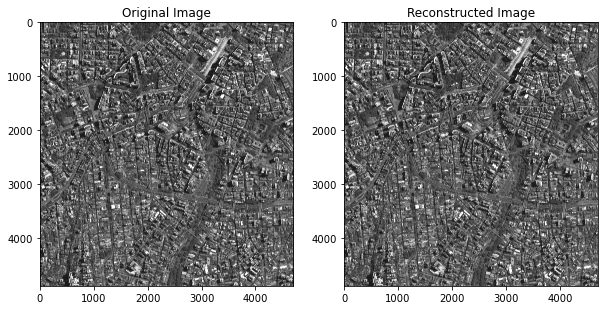

In [101]:
patch_size = 256
overlap = 0.3
img_patches = extract_patches({'image': norm_img_array, 'mask': np.zeros_like(norm_img_array).astype(np.int32), 'nodata_mask': np.zeros_like(norm_img_array).astype(np.int32)}, patch_size, overlap)[0]
reconstructed_img = reconstruct_image_weighted(img_patches, {'image': norm_img_array, 'mask': np.zeros_like(norm_img_array).astype(np.int32), 'nodata_mask': np.zeros_like(norm_img_array).astype(np.int32)}, patch_size, overlap)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(norm_img_array, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed Image')
plt.show()


RMSE: 7.983499e-09
Max diff: 1.7881393e-07
1.0 0.0


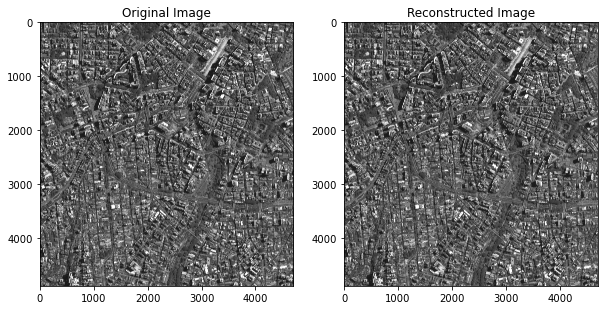

RMSE: 3.1373278e-05
Max diff: 0.0007324219
3680.5962 0.0


In [102]:
# 计算重建图像和原始图像的rmse
def rmse(img1, img2):
    return np.sqrt(np.mean((img1 - img2) ** 2))

print('RMSE:', rmse(norm_img_array, reconstructed_img))
print('Max diff:', np.max(np.abs(norm_img_array - reconstructed_img)))
print(np.max(reconstructed_img), np.min(reconstructed_img))

# 用最大最小值还原图像，看看效果，然后计算差异
original_img = norm_img_array * (max_value - min_value) + min_value
final_img = reconstructed_img * (max_value - min_value) + min_value
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(final_img, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

print('RMSE:', rmse(original_img, final_img))
print('Max diff:', np.max(np.abs(original_img - final_img)))
print(np.max(final_img), np.min(final_img))

